In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, GlobalAveragePooling2D, Dropout, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
fpath = "C:/Users/kaiqu/lamia-projeto-final/dogbreed/images/Images"

In [30]:
img_size = 128
batch_size = 32
train = tf.keras.utils.image_dataset_from_directory(
    fpath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode ="categorical"
)

val = tf.keras.utils.image_dataset_from_directory(
    fpath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [31]:
class_names = train.class_names
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [32]:
names=[]
for name in class_names :
    names.append(name.split("-")[1])

print(names[:10])

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']


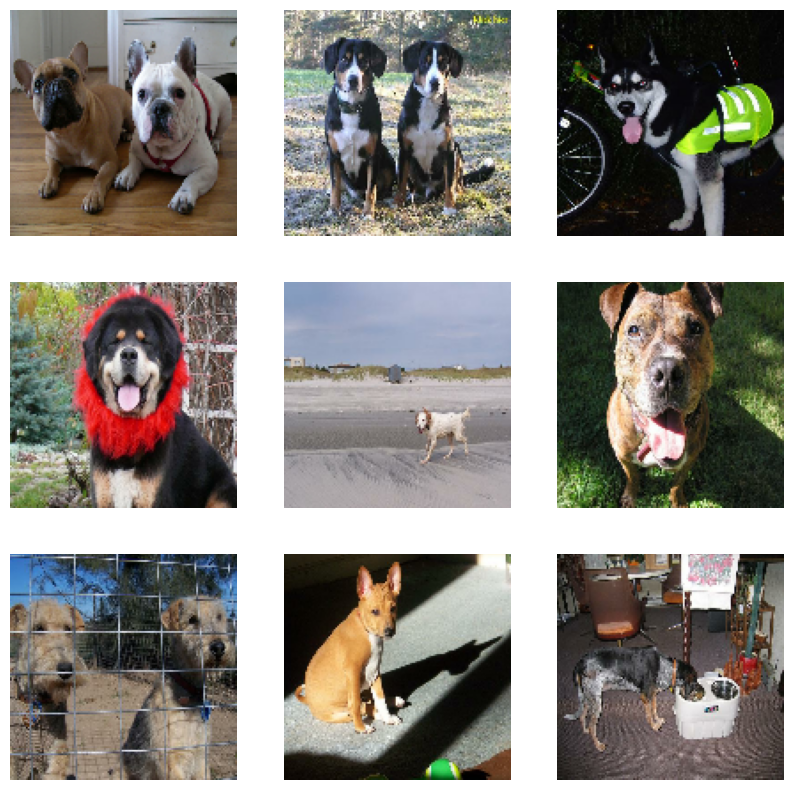

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

base_model = InceptionResNetV2(weights="imagenet", include_top=False)
base_model.trainable = False

model = Sequential([
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input, input_shape=(img_size, img_size, 3)),

    base_model,
    GlobalAveragePooling2D(), # converte 2d
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),

    tf.keras.layers.Dense(120, activation="softmax")
    ])

In [ ]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
)

In [ ]:
model.build((None, img_size, img_size, 3))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 128, 128, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [ ]:
model_name = "model.h5"
monitor = 'val_loss'

checkpoint = ModelCheckpoint(
    model_name,
    monitor = monitor,
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

early_stopping = EarlyStopping(
    monitor = monitor,
    patience =5,
    restore_best_weights =True,
    verbose =1
    )

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(
    monitor = monitor,
    factor =0.2,
    patience =3,
    min_lr =0.0001)


In [49]:
history = model.fit(train, epochs=30, validation_data=val, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/30


515/515 [==============================] - ETA: 0s - loss: 4.6983 - accuracy: 0.0186
Epoch 1: val_loss improved from -inf to 4.68975, saving model to model.h5
515/515 [==============================] - 175s 340ms/step - loss: 4.6983 - accuracy: 0.0186 - val_loss: 4.6897 - val_accuracy: 0.0170 - lr: 0.0010
Epoch 2/30
125/515 [======>.......................] - ETA: 2:06 - loss: 4.6789 - accuracy: 0.0225

KeyboardInterrupt: 

In [ ]:
best_model_accuracy = max(history.history['accuracy'])
best_model_val_accuracy = max(history.history['val_accuracy'])

print(f'Training Accuracy: {(best_model_accuracy * 100):.2f}%')
print(f'Validation Accuracy: {(best_model_val_accuracy * 100):.2f}%')

Training Accuracy: 53.86%
Validation Accuracy: 61.90%


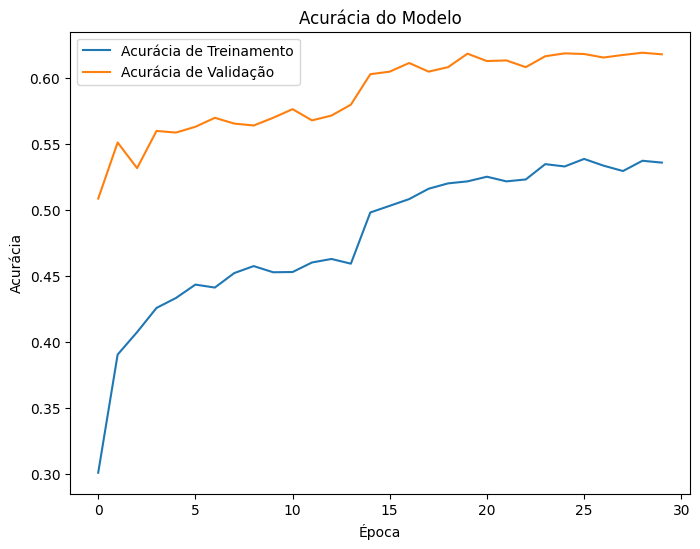

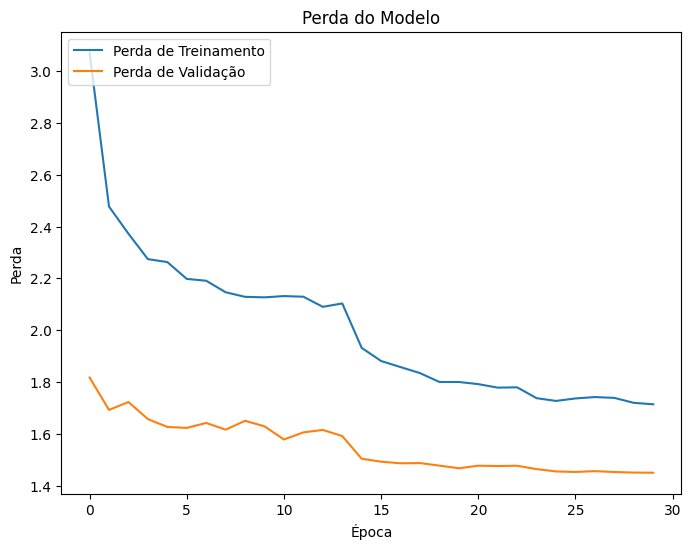

In [ ]:
# Plot de Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

# Plot de Perda
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def img_predict(filename):
    # Carregar e redimensionar a imagem com PIL
    img = Image.open(filename).convert('RGB')
    img = img.resize((128, 128))

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Converter para array e pré-processar
    img = np.array(img, dtype='float32')
    img = preprocess_input(img)

    # Fazer a predição (supondo que 'model' já esteja carregado)
    probs = model.predict(np.expand_dims(img, axis=0))

    # Exibe as 5 raças mais prováveis
    for idx in probs.argsort()[0][::-1][:5]:
        print(f"{probs[0][idx]*100:.2f}%\t", class_names[idx].split("-")[-1])

    print("Probabilidade máxima:", probs.max())


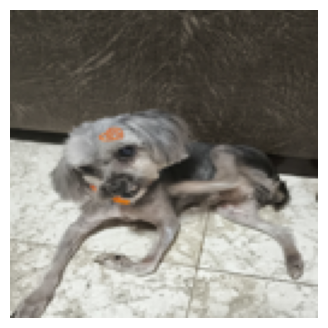

1/1 [==============================] - 0s 47ms/step
1.42%	 basenji
1.31%	 Italian_greyhound
1.29%	 Lakeland_terrier
1.28%	 Chesapeake_Bay_retriever
1.23%	 pug
Probabilidade máxima: 0.014187225


In [ ]:
img_predict('susie.jpg')